In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [85]:
train = pd.read_csv("dataset/train.csv")
# train.info()
test = pd.read_csv("dataset/test.csv")
train.dropna(inplace=True,axis=1)
test.dropna(inplace=True,axis=1)

In [86]:
X_train = train.drop(columns=["SalePrice"])
y_train = train["SalePrice"]

X_train.head
# y_train.head()
numerical_cols_train = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols_train = X_train.select_dtypes(include=['object']).columns


numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num_tr', numerical_transformer, numerical_cols_train),
        ('cat', categorical_transformer, categorical_cols_train)
    ])

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)




In [87]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train = X_train.toarray()
X_test = X_test.toarray()


In [88]:

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [89]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [90]:
class HousePriceNN(nn.Module):
    def __init__(self):
        super(HousePriceNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [91]:
model = HousePriceNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [92]:
num_epochs = 100
train_losses = []
val_losses = []
early_stopping_patience = 10
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

Epoch 1/100, Train Loss: 38884848850.4110, Val Loss: 39649806784.8767
Epoch 2/100, Train Loss: 38845627518.2466, Val Loss: 39521964340.6027
Epoch 3/100, Train Loss: 38397229420.7123, Val Loss: 38514432813.5890
Epoch 4/100, Train Loss: 36190277856.4384, Val Loss: 34644687829.9178
Epoch 5/100, Train Loss: 29845704535.6712, Val Loss: 25419223544.9863
Epoch 6/100, Train Loss: 17968560675.0685, Val Loss: 12014524710.5753
Epoch 7/100, Train Loss: 6263679516.0548, Val Loss: 3420503581.8082
Epoch 8/100, Train Loss: 2188692679.0137, Val Loss: 2151698135.6712
Epoch 9/100, Train Loss: 1852269425.9726, Val Loss: 1972454037.9178
Epoch 10/100, Train Loss: 1816588152.9863, Val Loss: 1803747392.0000
Epoch 11/100, Train Loss: 1676702869.0411, Val Loss: 1723135650.1918
Epoch 12/100, Train Loss: 1630781954.6301, Val Loss: 1672459036.4932
Epoch 13/100, Train Loss: 1514995386.7397, Val Loss: 1580739422.9041
Epoch 14/100, Train Loss: 1557366065.0959, Val Loss: 1658605448.9863
Epoch 15/100, Train Loss: 15860

In [93]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [94]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 1072974822.5753


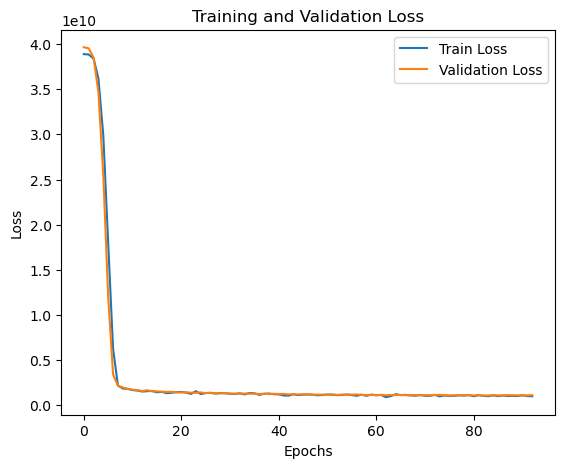

In [95]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

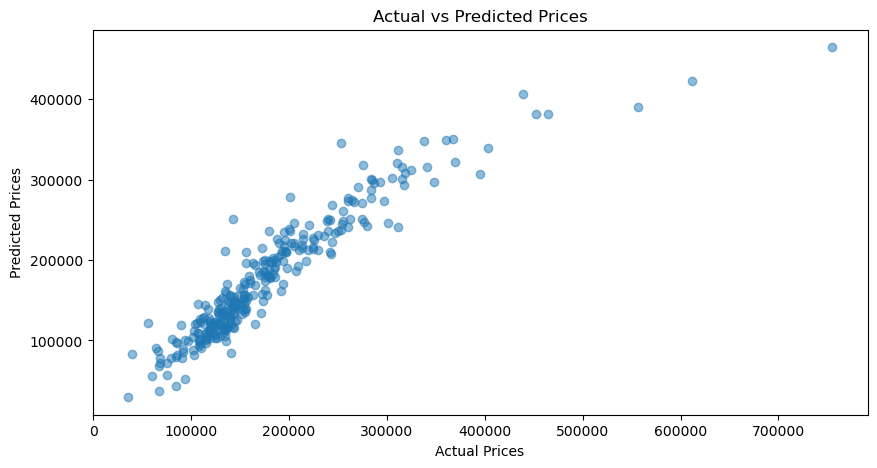

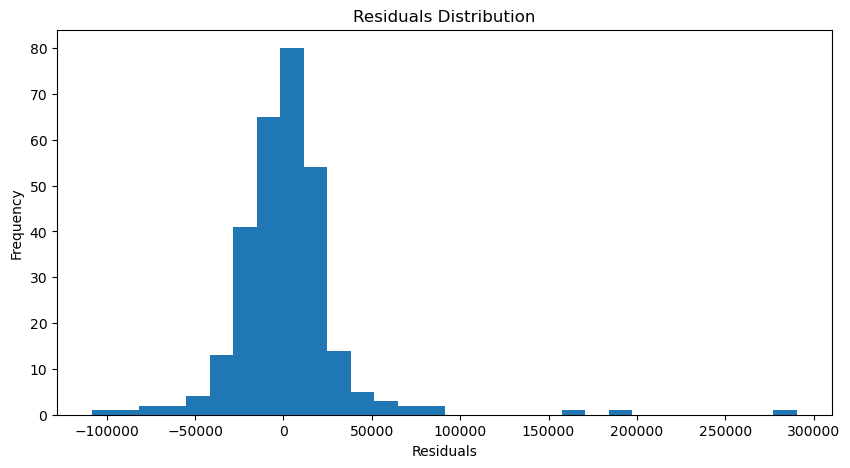

In [96]:
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

y_pred = y_pred_tensor.numpy()

# Plot predicted vs actual prices
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

# Plot residuals
residuals = y_test.values - y_pred.flatten()
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()